# Importing of packages

In [1]:
#packages
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Functions

In [20]:
#functions
def sketch_matrix(m, n_columns, non_zero_entries):
    #matrix with all zero entries
    S = np.zeros((m, n_columns))
    scaling_factor = 1 / np.sqrt(non_zero_entries)
    #loop through each columns to edit the non zero entries in
    for col in range(n_columns):
        # Randomly select position of non_zero entries
        nz_positions = np.random.choice(m, non_zero_entries, replace=False)
        
        # Randomly assign values of either 1 or -1 to these positions
        values = np.random.choice([1, -1], non_zero_entries)* scaling_factor
        
        # Assign the values to the selected positions in the column
        for idx, value in zip(nz_positions, values):
            S[idx, col] = value
    
    return S

def svd_sketching_error(A, SA):
    """
    Computes the sketching error based on the singular values of A and SA.
    """
    # Compute singular values of A and SA
    singular_values_A = np.linalg.svd(A, compute_uv=False)
    singular_values_SA = np.linalg.svd(SA, compute_uv=False)

    # Min and max singular values of A
    min_svd_A = np.min(singular_values_A)
    max_svd_A = np.max(singular_values_A)

    # Min and max singular values of SA
    min_svd_SA = np.min(singular_values_SA)
    max_svd_SA = np.max(singular_values_SA)

    # Compute the deviations from the original singular values
    min_svd_error = abs(1 - (min_svd_SA / min_svd_A))
    max_svd_error = abs(1 - (max_svd_SA / max_svd_A))

    return min_svd_error, max_svd_error

#svd of matrix
def compute_svd(matrix):
    # SVD computation only keep the singular values
    _, s, _ = np.linalg.svd(matrix, full_matrices=False)
    return np.min(s), np.max(s)

#Higher leverage scores indicate more influential data points.
def estimate_leverage_scores(A, R, gamma):
    """Estimate leverage scores ˜li for each row using matrix R (similar to Lemma 5.1)."""
    n, d = A.shape
    k = int(np.ceil(d / gamma))  # Choose k based on γ
    G = np.random.randn(d, k) / np.sqrt(k) #scale the matrix
    
    # Compute the leverage scores ˜li = || e_i^T AR G ||_2^2
    ARG = A @ (R @ G)
    leverage_scores = np.sum(ARG ** 2, axis=1)  # || e_i^T AR G ||_2^2
    
    return leverage_scores

def fast_least_squares_sgd(A, b, non_zero_entries, m, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Fast least squares via preconditioned mini-batch SGD using sketch matrix and leverage scores.
    
    Parameters:
    - A: (n, d) NumPy array (or sparse matrix), the design matrix.
    - b: (n,) NumPy array, the target vector.
    - T: Number of SGD iterations.
    - eta: Learning rate.
    - gamma: Approximation parameter for leverage score estimation.
    - batch_size: Number of rows sampled per SGD iteration.
    
    Returns:
    - x: (d,) NumPy array, the estimated least squares solution.
    """
    n, d = A.shape

    # Step 1: Generate the sketch matrix S using the sketch_matrix function
    S = sketch_matrix(m, n, non_zero_entries)
    # Step 2: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd_error, max_svd_error = svd_sketching_error(A, SA)

    # Step 3: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 4: Compute leverage score estimates
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 5: Compute initial x0 by solving (SAx = Sb)
    x = np.linalg.lstsq(SA, Sb, rcond=None)[0]

    # Step 6: Perform mini-batch SGD
    for t in range(T):
        # Step 6.1: Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Step 6.2: Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Step 6.3: Compute gradient of the least squares loss
        gt = 2 * StA.T @ (StA @ x - Stb)

        # Step 6.4: Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x , min_svd_error , max_svd_error

def compute_effective_dimension(A, lambda_reg):
    """Computes the lambda-effective dimension d_lambda."""
    d = A.shape[1]
    I = np.eye(d)
    return np.trace(A.T @ A @ np.linalg.inv(A.T @ A + lambda_reg * I))

def fast_least_squares_sgd_regularized(A, b, non_zero_entries, m, lambda_reg, T=100, eta=0.01, gamma=0.1, batch_size=10):
    """
    Implements fast least squares using mini-batch SGD with scaled regularization.

    Parameters:
    - A: (n, d) NumPy array (design matrix).
    - b: (n,) NumPy array (target vector).
    - lambda_reg: Regularization parameter λ.
    - m: Sketching matrix size.
    
    Returns:
    - x: (d,) NumPy array (estimated solution).
    """
    n, d = A.shape

    # Step 1: Compute effective dimension and scaled regularization λ'
    d_lambda = compute_effective_dimension(A, lambda_reg)
    lambda_scaled = lambda_reg * (1 - d_lambda / m)

    # Step 2: Generate sketch matrix
    S = sketch_matrix(m, n, non_zero_entries)
    
    # Step 3: Compute SA and Sb
    SA = S @ A
    Sb = S @ b
    min_svd_error, max_svd_error = svd_sketching_error(A, SA)

    # Step 4: Compute QR decomposition of SA
    Q, R_inv = np.linalg.qr(SA)
    R = np.linalg.inv(R_inv)

    # Step 5: Compute leverage scores
    leverage_scores = estimate_leverage_scores(A, R, gamma)
    leverage_probs = leverage_scores / np.sum(leverage_scores)  # Normalize

    # Step 6: Solve for initial x0 using regularized least squares
    I_d = np.eye(d)
    x = np.linalg.solve(SA.T @ SA + lambda_scaled * I_d, SA.T @ Sb)

    # Step 7: Perform mini-batch SGD
    for t in range(T):
        # Sample batch indices based on leverage scores
        batch_indices = np.random.choice(n, size=batch_size, p=leverage_probs)
        
        # Construct StA and Stb for mini-batch
        StA = A[batch_indices]
        Stb = b[batch_indices]

        # Compute gradient with regularization
        gt = 2 * (StA.T @ (StA @ x - Stb) + lambda_scaled * x)

        # Update x using preconditioned gradient
        x = x - eta * R @ (R.T @ gt)

    return x, lambda_scaled, min_svd_error , max_svd_error

# Effects of sparsity and number of rows on mse and sketching error

## m against mse and sketching error

In [26]:
#varying m
# Define parameters
n, d = 10000, 100  # Matrix size
m_values = list(range(100,7000 + 1, 100))  # Different sketch sizes
non_zero_entries = 10
# Store results
results = []
np.random.seed(42)  # for reproducibility
A = np.random.randn(n, d)

true_coefficients = np.random.randn(d)

b = A @ true_coefficients

In [22]:
for m in m_values:
    # Compute estimated x
    x_estimated, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    mse = mean_squared_error(b, A @ x_estimated)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results = pd.DataFrame(results)

In [29]:
df_results.head()

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error
0,100,1.156471e-27,10,0.987983,0.816591
1,200,9.866730e-28,10,0.656826,0.516347
2,300,3.866079e-28,10,0.507107,0.413347
3,400,4.217395e-28,10,0.425871,0.351027
4,500,5.388238e-28,10,0.356215,0.339060


In [33]:
df_results['sketching_error'] = df_results[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results["inv_squared_sketching_error"] = 1 / (df_results["sketching_error"] ** 2)
df_results.head()

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,100,1.156471e-27,10,0.987983,0.816591,0.987983,1.024474
1,200,9.866730e-28,10,0.656826,0.516347,0.656826,2.317925
2,300,3.866079e-28,10,0.507107,0.413347,0.507107,3.888668
3,400,4.217395e-28,10,0.425871,0.351027,0.425871,5.513719
4,500,5.388238e-28,10,0.356215,0.339060,0.356215,7.880907


In [35]:
#varying m
# Define parameters
n, d = 10000, 100  # Matrix size
m_values = list(range(7100,n + 1, 100))  # Different sketch sizes
non_zero_entries = 10
# Store results
results = []

for m in m_values:
    # Compute estimated x
    x_estimated, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    mse = mean_squared_error(b, A @ x_estimated)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results2 = pd.DataFrame(results)

In [36]:
df_results2['sketching_error'] = df_results2[["Min_SVD_Error", "Max_SVD_Error"]].max(axis=1)
df_results2["inv_squared_sketching_error"] = 1 / (df_results2["sketching_error"] ** 2)
df_results2.head()

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,7100,3.393759e-28,10,0.053162,0.064826,0.064826,237.957348
1,7200,6.518972e-28,10,0.059509,0.052476,0.059509,282.379732
2,7300,6.441638e-28,10,0.051885,0.051762,0.051885,371.462572
3,7400,4.852600e-28,10,0.048958,0.050511,0.050511,391.951375
4,7500,4.244328e-28,10,0.049723,0.047729,0.049723,404.461460


In [37]:
df_merged = pd.concat([df_results, df_results2], ignore_index=True)
df_merged.to_csv('varying_m_data_application.csv', index=False)

In [38]:
df_merged

,m,MSE,Sparsity,Min_SVD_Error,Max_SVD_Error,sketching_error,inv_squared_sketching_error
0,100,1.156471e-27,10,0.987983,0.816591,0.987983,1.024474
1,200,9.866730e-28,10,0.656826,0.516347,0.656826,2.317925
2,300,3.866079e-28,10,0.507107,0.413347,0.507107,3.888668
3,400,4.217395e-28,10,0.425871,0.351027,0.425871,5.513719
4,500,5.388238e-28,10,0.356215,0.339060,0.356215,7.880907
...,...,...,...,...,...,...,...
95,9600,5.179395e-28,10,0.040627,0.047454,0.047454,444.072213
96,9700,5.040233e-28,10,0.042033,0.040571,0.042033,566.014123
97,9800,5.325310e-28,10,0.040315,0.046604,0.046604,460.418625
98,9900,5.952592e-28,10,0.033576,0.038237,0.038237,683.963663


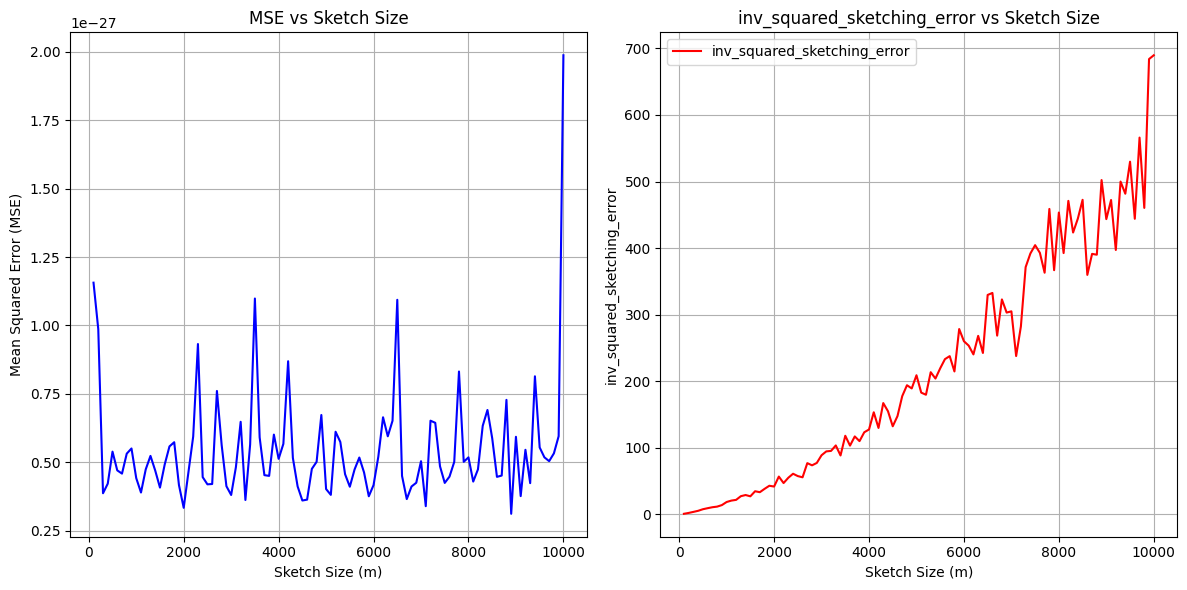

In [39]:
# Plot MSE vs m
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_merged["m"], df_merged["MSE"], label="MSE", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Sketch Size")
plt.grid(True)

# Plot Min_SVD_Error and Max_SVD_Error vs m
plt.subplot(1, 2, 2)
plt.plot(df_merged["m"], df_merged["inv_squared_sketching_error"], label="inv_squared_sketching_error", color='red')
plt.xlabel("Sketch Size (m)")
plt.ylabel("inv_squared_sketching_error")
plt.title("inv_squared_sketching_error vs Sketch Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

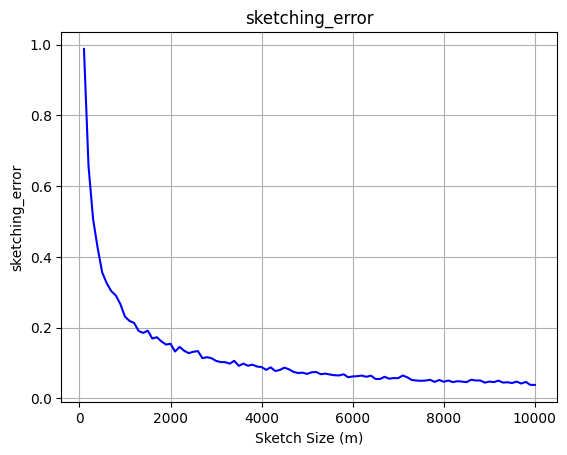

In [40]:
plt.plot(df_merged["m"], df_merged["sketching_error"], label="sketching_error", color='blue')
plt.xlabel("Sketch Size (m)")
plt.ylabel("sketching_error")
plt.title("sketching_error")
plt.grid(True)

In [ ]:
#varying s, elbow
n, d = 10000, 100  # Matrix size
m = 2000
non_zero_entries_list = list(range(2,m + 1 ,2))
# Store results
results = []

for non_zero_entries in non_zero_entries_list:
    # Compute estimated x
    x_estimated, min_svd_error, max_svd_error  = fast_least_squares_sgd(A, b, non_zero_entries,m)
    mse = mean_squared_error(b, A @ x_estimated)
    # Store results for plotting
    results.append({"m": m, "MSE": mse, "Sparsity": non_zero_entries, "Min_SVD_Error": min_svd_error,"Max_SVD_Error": max_svd_error})

# Combine all results
df_results = pd.DataFrame(results)